# TensorNetwork basics

This notebook describes the basics operations involved in tensor networks using the python library [TensorNetwork](https://github.com/google/TensorNetwork).

In [1]:
import numpy as np
import jax
import tensornetwork as tn
import networkx as nx
import matplotlib.pyplot as plt

### Tensor network notation

A tensor is simply a multidimensional array. The dimension of the array is the *rank* of the tensor. For example, a vector $v_i$ is a rank-1 tensor, a matrix $M_{ij}$ is a rank-2 tensor, a 3D array $T_{ijk}$ is a rank-3 tensor, and so on. A quite useful diagrammatic notation can be used to visualize tensors and how they are connected in a network. In this notation, tensors are represented by shapes (**nodes**) and their indices by edges, as in the picture below 

<img src='./figures/TN_notation.png' alt="drawing" width="400"/>

When we build a tensor network, we connect tensor by means of a **contraction**. For example, a possible contraction between a rank-1 tensor $A$ and a rank-4 tensor $B$ is

$ C_{jkl}=\sum_i A_{i}B_{ijkl} $

Note that in general the resulting tensor has a rank that is different than the ranks of the tensors being contracted. The rank of the resulting tensor will be the number of indices that are not contracted (sometimes also referred to as **dangling edges**). Diagrammatically, the contraction is represented by connecting the edges of the tensors like this:

     |           |
     ● —  =  ● — ● — 
     |           |
 
Let's see how these operations are implemented in TensorNetwork.

**Create a tensor object (Node)**

In [2]:
node = tn.Node(np.eye(3), name='Test node')

print(f'Name: {node}') # Print node name
print(node.tensor) # Access tensor values
print(f'Rank of tensor is: {node.get_rank()}') # Get tensor rank
print(node.edges) # Get information about edges

Name: Test node
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Rank of tensor is: 2
[
Edge(Dangling Edge)[0] 
, 
Edge(Dangling Edge)[1] 
]


**Create tensors A and B**

In [3]:
A = tn.Node(np.random.randint(10, size=2), name='A', axis_names=['i'])
B = tn.Node(np.random.randint(10, size=(2, 3, 3, 4)), 'B', axis_names=['i', 'j', 'k', 'l'])

print(f'A = {A.tensor} \n')
print(f'B = {B.tensor} \n')
print(f'Shape of A is: {A.tensor.shape}')
print(f'Shape of B is: {B.tensor.shape}')

A = [6 9] 

B = [[[[8 3 3 2]
   [6 7 3 1]
   [1 4 1 3]]

  [[3 2 2 2]
   [2 6 4 4]
   [2 5 9 8]]

  [[7 0 0 3]
   [3 2 1 2]
   [7 1 8 6]]]


 [[[0 5 1 3]
   [8 7 0 1]
   [4 1 0 8]]

  [[6 8 4 9]
   [8 8 3 2]
   [1 8 0 1]]

  [[6 6 2 1]
   [5 4 3 8]
   [4 3 4 4]]]] 

Shape of A is: (2,)
Shape of B is: (2, 3, 3, 4)


**Visualizing tensors with Graphviz**

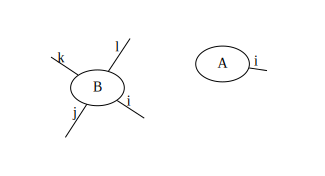

In [4]:
tn.to_graphviz([A, B])

**Create an edge that connects A and B**

The edge of A is acessed as A[0], while the edges of B are B[0], B[1], B[2], and B[3]. Note that the dimensions of the indices being contracted need to be the same. We can also use their (optional) axis names instead. For example, B[0] is B['i'].

In [5]:
edge = A[0] ^ B[0] # This is a shortcut for tn.connect(A[0], B[0])

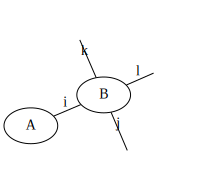

In [6]:
tn.to_graphviz([A, B])

**Contract edge to obtain C**

In [7]:
C = tn.contract(edge)
C.name = 'C'

In [8]:
print(f'C = {C.tensor}\n')
print(f'Shape of C is: {C.tensor.shape}')
print(f'Rank of C is: {C.get_rank()}')

C = [[[ 48  63  27  39]
  [108 105  18  15]
  [ 42  33   6  90]]

 [[ 72  84  48  93]
  [ 84 108  51  42]
  [ 21 102  54  57]]

 [[ 96  54  18  27]
  [ 63  48  33  84]
  [ 78  33  84  72]]]

Shape of C is: (3, 3, 4)
Rank of C is: 3


The equivalent operation in Numpy would be

In [9]:
np.tensordot(A.tensor, B.tensor, (0, 0))

array([[[ 48,  63,  27,  39],
        [108, 105,  18,  15],
        [ 42,  33,   6,  90]],

       [[ 72,  84,  48,  93],
        [ 84, 108,  51,  42],
        [ 21, 102,  54,  57]],

       [[ 96,  54,  18,  27],
        [ 63,  48,  33,  84],
        [ 78,  33,  84,  72]]])

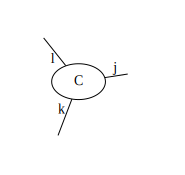

In [10]:
tn.to_graphviz([C])

### More tensor operations

**Trace:** When the contraction happens between two edges of the same tensor

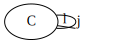

In [11]:
trace_edge = C[0] ^ C[1]
tn.to_graphviz([C])

In [12]:
D = tn.contract(trace_edge)
D.name = 'D'
print(D.tensor)

[210 204 162 153]


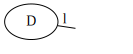

In [13]:
tn.to_graphviz([D])

**SVD node splitting**

The Singular value decomposition (SVD) is used to “split a node”. It takes a single node and splits it into three new nodes.

For a matrix $M$, the SVD decomposition is given by

$M = USV^*$

where $S$ is a diagonal matrix containing the "singular values". 

In [14]:
M = tn.Node(np.random.randint(10, size=(3, 4)))
print(M.tensor)

[[1 0 5 5]
 [3 2 1 6]
 [6 5 2 3]]


In [15]:
U, S, Vh, _ = tn.split_node_full_svd(M, left_edges=[M[0]], right_edges=[M[1]])

In [16]:
print(f'U = {U.tensor}\n')
print(f'S = {S.tensor}\n')
print(f'Vh = {Vh.tensor}')

U = [[ 0.48512883  0.75855452  0.43502306]
 [ 0.57064842  0.10232165 -0.81479486]
 [ 0.6625786  -0.64352569  0.38322876]]

S = [[11  0  0]
 [ 0  5  0]
 [ 0  0  2]]

Vh = [[ 0.52536991  0.37911381  0.36781578  0.66706126]
 [-0.51189106 -0.55168874  0.4775423   0.45338773]
 [ 0.1085689   0.10727475  0.79618323 -0.58548884]]


In [17]:
((U @ S) @ Vh).tensor # The symbol @ is a shortcut for tn.contract 

array([[0.95656654, 0.02401348, 4.46674388, 4.76991138],
       [2.8590062 , 1.92268537, 1.25569099, 5.37329551],
       [5.55937616, 4.6204706 , 1.7544624 , 2.95420008]])

In TensorNetwork, there is also a simplified decomposition in which a factor of the square root of $S$ is absorbed into $U$ and $V^*$.

In [18]:
U, Vh, _ = tn.split_node(M, left_edges=[M[0]], right_edges=[M[1]])

print(f'U = {U.tensor}\n')
print(f'Vh = {Vh.tensor}')

U = [[ 1.60899029  1.69617948  0.61521551]
 [ 1.89262671  0.22879816 -1.15229394]
 [ 2.1975246  -1.4389672   0.54196731]]

Vh = [[ 1.74245488  1.25737827  1.21990692  2.21239191]
 [-1.14462321 -1.23361352  1.06781705  1.01380578]
 [ 0.15353961  0.1517094   1.12597313 -0.82800626]]


In [19]:
(U @ Vh).tensor

array([[0.95656654, 0.02401348, 4.46674388, 4.76991138],
       [2.8590062 , 1.92268537, 1.25569099, 5.37329551],
       [5.55937616, 4.6204706 , 1.7544624 , 2.95420008]])